In [1]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
event = 'event000001000'

print('Loading event {}'.format(path+event))

hits, cells, particles, truth = load_event(path+event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/event000001000
event000001000 memory usage 18.46 MB


   hit_id          x         y       z  volume_id  layer_id  module_id
0       1 -64.409897 -7.163700 -1502.5          7         2          1
1       2 -55.336102  0.635342 -1502.5          7         2          1
2       3 -83.830498 -1.143010 -1502.5          7         2          1
3       4 -96.109100 -8.241030 -1502.5          7         2          1
4       5 -62.673599 -9.371200 -1502.5          7         2          1


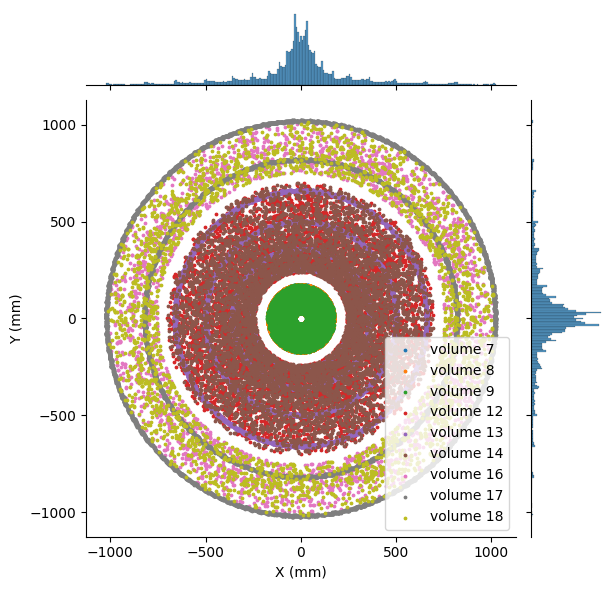

In [2]:
'''
Representación de los hits
'''
print(hits.head())

g = sns.jointplot(x=hits.x, y=hits.y, s=1, height=6)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
# plt.show()
# # Iterar sobre los volúmenes únicos
# for volume in hits['volume_id'].unique():  
#     fig = plt.figure(figsize=(12, 8))
#     ax = fig.add_subplot(111, projection='3d')
#     hits_volume = hits[hits['volume_id'] == volume]  # Filtrar los hits por volumen
#     ax.scatter(hits_volume['x'], hits_volume['y'], hits_volume['z'], 
#                label=f'Volume {volume}', s=5, alpha=0.75)

# ax.legend()
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Distribución de hits por volumen')
# plt.show()

        particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits         r      phi     theta  
0  -0.203492 -1      8  0.079048  2.32629  2.969372  
1   2.010060  1     11  0.079048  2.32629  2.969372  
2   0.683881 -1      0  0.079048  2.32629  2.969372  
3   0.991616  1     12  0.079048  2.32629  2.969372  
4 -39.824902  1      3  0.079048  2.32629  2.969372  


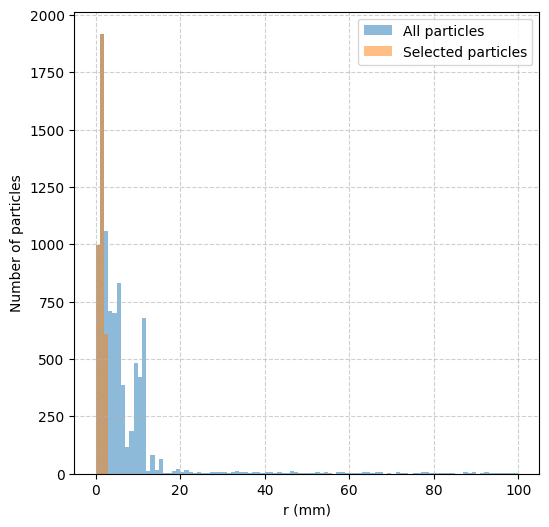

    hit_id          x         y       z  volume_id  layer_id  module_id
1        2 -55.336102  0.635342 -1502.5          7         2          1
9       10 -90.292900 -3.269370 -1502.5          7         2          1
10      11 -59.182999 -0.670508 -1502.5          7         2          1
12      13 -72.533997  2.642190 -1502.5          7         2          1
14      15 -63.436501 -3.262220 -1502.5          7         2          1
Los datos que tomo son un 29.4380% de los datos originales


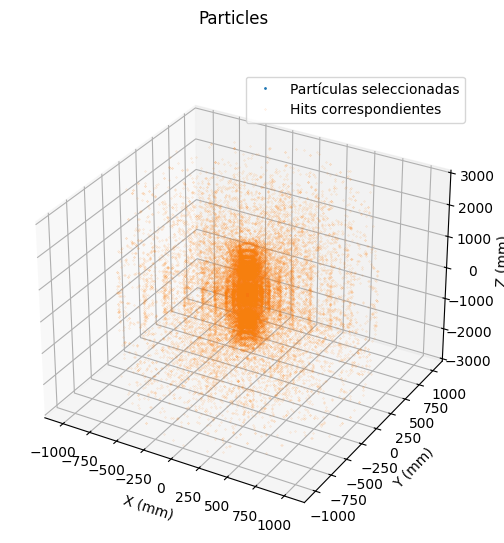

In [3]:
#============== CONSIDERO SOLO LOS HITS DE LA PARTE CENTRAL DEL DETECTOR ==============#

def distance(particle):
    ''' Distancia en mm de la partícula al origen'''
    return np.sqrt(particle.vx**2 + particle.vy**2 + particle.vz**2)

particles['r'] = distance(particles)
particles['phi'] = np.arctan2(particles.vy, particles.vx)
particles['theta'] = np.arccos(particles.vz / particles.r)

print(particles.head())

# Voy a coger solo las partículas con r < 2.6
particles_all = particles
particles = particles[particles.r < 2.6]

# Con ese radio, voy a coger solo las partículas con z entre -25 y 25 mm
particles = particles[(particles.vz > -25) & (particles.vz < 25)]

# Histograma normalizado a 1 de la variable r
plt.figure(figsize=(6, 6))
plt.hist(particles_all.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='All particles')
plt.hist(particles.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='Selected particles')
plt.legend()
plt.xlabel('r (mm)')    
plt.ylabel('Number of particles')
plt.grid(linestyle='--', alpha=0.6)
plt.show()

# Del truth cojo solo las partículas que están en particles
truth = truth[truth.particle_id.isin(particles.particle_id)]

# Cojo ahora los hits_id que están en truth
hits_all = hits
hits = hits[hits.hit_id.isin(truth.hit_id)]
print(hits.head())

print("Los datos que tomo son un {:.4f}% de los datos originales".format(hits.shape[0]/hits_all.shape[0]*100))


# Represento el dataset de particles en 3D
fig = plt.figure(figsize=(6, 6))
plt.suptitle('Particles')
ax = fig.add_subplot(111, projection='3d')
ax.plot(particles.vx, particles.vy, particles.vz, 'o', markersize=1, label = 'Partículas seleccionadas')
#ax.plot(particles_all.vx, particles_all.vy, particles_all.vz, 'x', alpha  = .6, markersize = .6, label = 'Todas las partículas')
ax.plot(hits.x, hits.y, hits.z, 'o', markersize=.2, alpha= .4, label = 'Hits correspondientes')
ax.legend(loc = 'best')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
plt.show()

Total de capas entre los volúmenes seleccionados: 10


Trayectorias desde volumen 8: 100%|██████████| 3299/3299 [00:55<00:00, 59.39it/s]


Cantidad de tracks reconstruidos: 3299
Positivos: 50.2880 %, Negativos: 49.7120 %


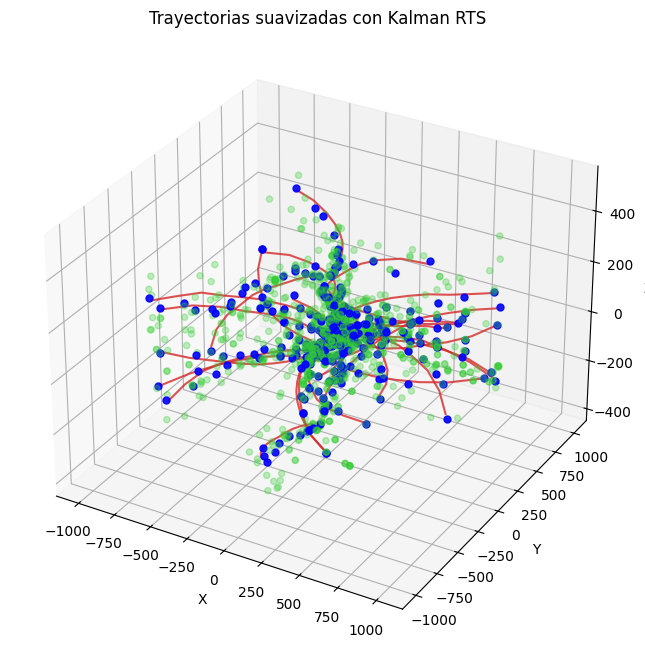

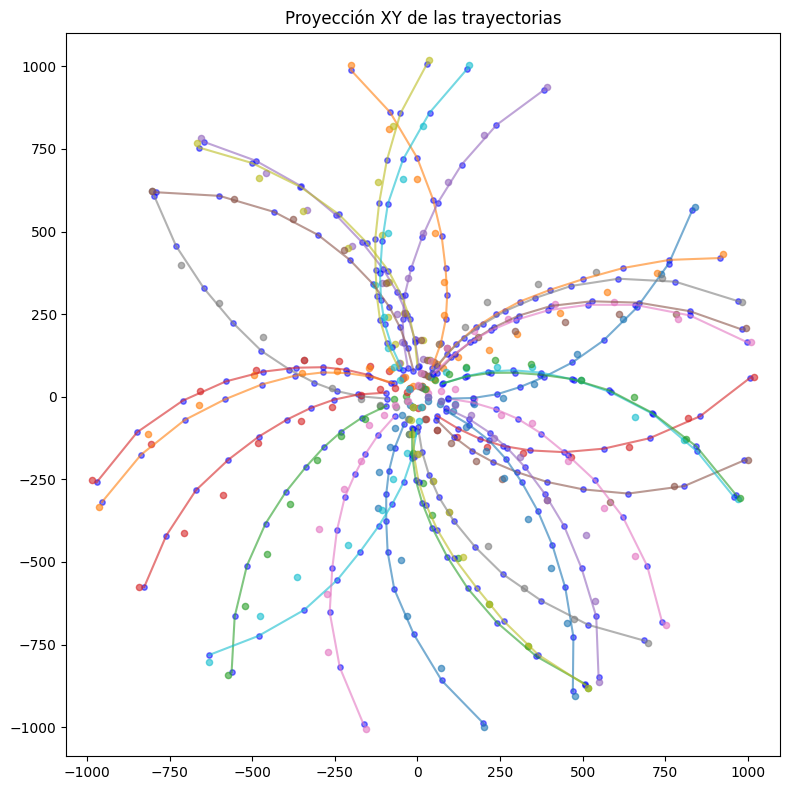

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import importlib
import kalman_filter
importlib.reload(kalman_filter)
from kalman_filter import apply_kalmanfilter
from top_momentum import top_momentum


# ======== PARÁMETROS CONFIGURABLES ========
DT = 1
COS_THRESHOLD = 0
Q_COEFF = 0.1
REDUCTION_FRACTION = 1.0

TOP_PARTICLES = False
if TOP_PARTICLES:
    hits, truth, top_particles = top_momentum(path, event)
    REDUCTION_FRACTION = 1.0
    if (top_particles['pt'] > 3).any():  # si hay alguna con pt > x
        Q_COEFF = 0.01

TRACKS_TO_DRAW = 30

VISUALIZAR = True
HITS_CERCANOS = True

SMOOTHING = True

OCTANTE = False

# Matrices Kalman
F = np.array([[1, DT, 0,  0,  0,  0],
              [0,  1,  0,  0,  0,  0],
              [0,  0,  1, DT,  0,  0],
              [0,  0,  0,  1,  0,  0],
              [0,  0,  0,  0,  1, DT],
              [0,  0,  0,  0,  0,  1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])

C = np.eye(6) * 1e-3
Q = np.eye(6) * 1e-2
R = np.eye(3) * 1e-2


# ======== FUNCIONES AUXILIARES ========
def cos_angle(v1, v2):
    norm1, norm2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 1.0
    return np.clip(np.dot(v1, v2) / (norm1 * norm2), -1.0, 1.0)

def reduce_hits(hits, fraction=REDUCTION_FRACTION):
    return hits.sample(frac=fraction, random_state=42)

def campo_magnetico(z):
    z = z / 2750
    return 0.03 * z**3 - (0.55 - 0.3 * (1 - z**2)) * z**2 + 1.002

def get_hits_dict(hits, volume_ids, OCTANTE = OCTANTE):
    hits_dict_all = {}

    for volume_id in volume_ids:
        hits_volume = hits[hits.volume_id == volume_id].copy()
        hits_volume['r'] = np.sqrt(hits_volume.x**2 + hits_volume.y**2 + hits_volume.z**2)

        # Filtrar por el primer octante si OCTANTE es True
        if OCTANTE:
            hits_volume = hits_volume[(hits_volume['x'] > 0) & (hits_volume['y'] > 0) & (hits_volume['z'] > 0)]

        # Crear el diccionario de hits por capa
        hits_dict = {
            layer: reduce_hits(hits_volume[hits_volume.layer_id == layer])
            for layer in hits_volume['layer_id'].unique()
        }

        hits_dict_all[volume_id] = hits_dict

    return hits_dict_all


def get_initial_state(hit1, hit2):
    # Asumimos que el vertex está en el origen (0, 0, 0)
    v = hit2 - hit1
    v_unit = v / np.linalg.norm(v)
    velocity = np.linalg.norm(v)
    return np.array([
        hit1[0], v_unit[0]*velocity,
        hit1[1], v_unit[1]*velocity,
        hit1[2], v_unit[2]*velocity
    ]).reshape(-1, 1)


def apply_lorentz_correction(kf, Bz, Q_OVER_M):
    velocity = np.array([kf.x[1, 0], kf.x[3, 0], kf.x[5, 0]])
    force = Q_OVER_M * np.cross(velocity, np.array([0, 0, 3 * Bz]))
    new_velocity = velocity + DT*force
    kf.x[1], kf.x[3], kf.x[5] = new_velocity


# ======== PREPARACIÓN DE DATOS ========
volume_ids = hits['volume_id'].unique()
volume_ids = volume_ids[[1, 4, 7]]
first_volume = volume_ids[0]
hits_dict_all_volumes = get_hits_dict(hits, volume_ids)

first_layer = sorted(hits_dict_all_volumes[first_volume].keys())[0]
second_layer = sorted(hits_dict_all_volumes[first_volume].keys())[1]
vertex = np.array([0, 0, 0])

# Calcular el número de layers totales entre todos los volumenes
n_layers = sum(len(hits_dict_all_volumes[volume_id]) for volume_id in volume_ids)
print(f"Total de capas entre los volúmenes seleccionados: {n_layers}")


tracks = []
x_pred_all = []
hits_vecinos_por_track = []  
cos_values = []


positivos, negativos = 0, 0
# ======== CONSTRUCCIÓN DE TRACKS ========
for i in tqdm(range(len(hits_dict_all_volumes[first_volume][first_layer])), desc=f'Trayectorias desde volumen {first_volume}'):
    hit1 = hits_dict_all_volumes[first_volume][first_layer].iloc[i][['x', 'y', 'z']].values
    v1 = hit1 - vertex

    hits_second = hits_dict_all_volumes[first_volume][second_layer][['x', 'y', 'z']].values
    hit2 = hits_second[np.argmin(np.linalg.norm(hits_second - hit1, axis=1))]
    v2 = hit2 - vertex

    # hits_third = hits_dict_all_volumes[first_volume][first_layer][['x', 'y', 'z']].values
    # hit3 = hits_third[np.argmin(np.linalg.norm(hits_third - hit2, axis=1))]
    # v3 = hit3 - vertex

    if cos_angle(v1, v2) < COS_THRESHOLD: #and cos_angle(v2, v3) < COS_THRESHOLD:
        continue

    cos_values.append(cos_angle(v1, v2))

    # Inicializar el filtro de Kalman
    track_posit, hits_vecinos_por_track_posit, chi2_posit = apply_kalmanfilter(hit1, hit2, hits_dict_all_volumes, Q_COEFF, 
                                                get_initial_state, C, F, H, Q, R, volume_ids,  campo_magnetico, 
                                                apply_lorentz_correction, SMOOTHING, +1)

    track_negat, hits_vecinos_por_track_negat, chi2_negat = apply_kalmanfilter(hit1, hit2, hits_dict_all_volumes, Q_COEFF, 
                                                get_initial_state, C, F, H, Q, R, volume_ids,  campo_magnetico, 
                                                apply_lorentz_correction, SMOOTHING, -1)

    if chi2_posit < chi2_negat:
        tracks.append(track_posit)
        hits_vecinos_por_track.append(hits_vecinos_por_track_posit)
        positivos +=1
    else:
        tracks.append(track_negat)
        hits_vecinos_por_track.append(hits_vecinos_por_track_negat)
        negativos +=1
    
print(f'Cantidad de tracks reconstruidos: {len(tracks)}')
print(f'Positivos: {positivos/len(tracks)*100:.4f} %, Negativos: {negativos/len(tracks)*100:.4f} %')
    

# ======== VISUALIZACIONES ========
def visualizar_3D_hits_y_tracks():
    fig = plt.figure(figsize=(12, 8))

    # Subplot 3D
    ax = fig.add_subplot(111, projection='3d')

    if not HITS_CERCANOS:
        for volume_id in volume_ids:
            for layer in hits_dict_all_volumes[volume_id].keys():
                hits_layer = hits_dict_all_volumes[volume_id][layer]
                ax.scatter(hits_layer['x'], hits_layer['y'], hits_layer['z'], s=3, alpha=0.5)

    # Muestras aleatorias de las trayectorias
    muestras = random.sample(list(enumerate(tracks)), min(len(tracks), TRACKS_TO_DRAW))
    for i, (idx, track) in enumerate(muestras):
        ax.plot(track[:, 0], track[:, 1], track[:, 2], color='tab:red', alpha=0.8)

        if HITS_CERCANOS and idx < len(hits_vecinos_por_track):
            for best_hit, vecinos in hits_vecinos_por_track[idx]:
                # Plot best hit en azul
                ax.scatter(best_hit[0], best_hit[1], best_hit[2],
                           color='blue', s=25, alpha=0.9,
                           label='Best hit' if i == 0 else "")
                # Plot vecinos en verde (esto no se visualizará en la proyección XY)
                ax.scatter(vecinos[:, 0], vecinos[:, 1], vecinos[:, 2],
                           color='limegreen', s=20, alpha=0.3)

    ax.set_title('Trayectorias suavizadas con Kalman RTS')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Proyección XY 2D
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    
    # Mostrar proyección XY de las trayectorias sin los vecinos verdes
    for i, (idx, track) in enumerate(muestras):
        x, y, z = track[:, 0], track[:, 1], track[:, 2]
        ax2.plot(x, y, alpha=0.6)

        # Marcar todos los puntos del track
        for j in range(len(x)):
            ax2.scatter(x[j], y[j], s=15, color='blue', alpha=0.5)  # Marca cada hit considerado

        # Marcar los best_hits específicos de cada track con un color único
        if HITS_CERCANOS and idx < len(hits_vecinos_por_track):
            track_color = f"C{i}"  # Usar el mismo color por track (basado en el índice)
            vecinos_del_track = hits_vecinos_por_track[idx]
            for best_hit, vecinos in vecinos_del_track:
                ax2.scatter(best_hit[0], best_hit[1], s=20, color=track_color, alpha=0.6, label=f'Best hit Track {i}' if i == 0 else "")

    ax2.set_title('Proyección XY de las trayectorias')
    ax2.axis('equal')  # Para mantener la proporción de los ejes X e Y
    plt.tight_layout()

    plt.show()

    # # Histograma de cos(angle)
    # histAngle = plt.figure(figsize=(12, 6))
    # plt.hist(cos_values, bins=50)
    # plt.title('Distribución de cos(angle) entre hit1 y hit2')
    # plt.xlabel('cos(angle)')
    # plt.ylabel('Frecuencia')
    # plt.grid(linestyle='--', alpha=0.6)
    # # histAngle.show()

if VISUALIZAR:
    %matplotlib inline
    visualizar_3D_hits_y_tracks()

In [7]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from trackml.randomize import shuffle_hits
from trackml.score import score_event


# Filtrar solo los volúmenes en el DataFrame truth
truth_con_volumen = truth.merge(hits[['hit_id', 'volume_id']], on='hit_id', how='left')
truth_filtrado = truth_con_volumen[truth_con_volumen['volume_id'].isin(volume_ids)]
truth_filtrado = truth_filtrado[truth_filtrado['particle_id'] != 0]

def construir_trayectorias_truth_weight(truth_df, min_hits_por_particula=n_layers, OCTANTE=False):
    trayectorias_truth = []
    weights_truth = []
    grouped = truth_df.groupby('particle_id')

    for pid, grupo in grouped:
        if len(grupo) >= min_hits_por_particula:
            grupo_ordenado = grupo.sort_values('tz')
            tray = grupo_ordenado[['tx', 'ty', 'tz']].values
            weights = grupo_ordenado['weight'].values

            # Filtro angular
            v1 = tray[0] - vertex
            v2 = tray[1] - vertex if len(tray) > 1 else tray[-1] - vertex
            if cos_angle(v1, v2) < COS_THRESHOLD:
                continue

            # Filtrado por octante
            if OCTANTE:
                tray = tray[(tray[:, 0] > 0) & (tray[:, 1] > 0) & (tray[:, 2] > 0)]  # Filtro por primer octante

            trayectorias_truth.append(tray)
            weights_truth.append(weights)

    return trayectorias_truth, weights_truth


# Importamos las métricas
from metric_scores import valid_tracks_from_best_hits
min_ratio = 0.51

# Construir trayectorias y pesos del truth
trayectorias_truth, pesos_truth = construir_trayectorias_truth_weight(truth_filtrado)
print(f"Se reconstruyeron {len(trayectorias_truth)} trayectorias del truth.")
# Maximo de hits por trayectoria
max_hits = max([len(tray) for tray in trayectorias_truth])
print(f"Máximo de hits por trayectoria: {max_hits}")

# plt.figure(figsize=(12, 6))
# plt.hist([len(tray) for tray in trayectorias_truth], bins=50)
# plt.title('Distribución de la cantidad de hits por trayectoria del truth')
# plt.xlabel('Cantidad de hits por trayectoria')
# plt.ylabel('Frecuencia')   
# plt.grid(linestyle='--', alpha=0.6)
# plt.show()

# Media de hits por trayectoria
media_hits = np.mean([len(tray) for tray in trayectorias_truth])
print(f"Media de hits por trayectoria: {media_hits:.2f}")

print(truth_filtrado['particle_id'].value_counts().head(10))

# Mezclar los hits del truth
shuffled_truth = shuffle_hits(truth_filtrado, 0.05)

valid_tracks, valid_track_indices, track_to_pid = valid_tracks_from_best_hits(
    hits_vecinos_por_track, truth_filtrado, min_ratio=min_ratio)

total_tracks_reconstruidos = len(hits_vecinos_por_track)
precision = valid_tracks / total_tracks_reconstruidos * 100
recall = valid_tracks / len(trayectorias_truth) * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score:.2f}%")


# Score de referencia usando hits mezclados
score_with_shuffled = score_event(truth_filtrado, shuffled_truth)
if isinstance(score_with_shuffled, (float, np.float32)):
    print(f"Puntuación máxima posible: {score_with_shuffled:.4f}")
else:
    print("Puntuación máxima posible:")
    for metric, value in score_with_shuffled.items():
        print(f"{metric}: {value:.4f}")

Se reconstruyeron 796 trayectorias del truth.
Máximo de hits por trayectoria: 19
Media de hits por trayectoria: 11.74
particle_id
153125410987573248    19
117103142318899200    18
63051081977954304     17
153125617146003456    17
828665217654194176    17
4507791515451392      17
4504355541614592      17
58548032106397696     16
189151459227467776    16
864703566680424448    16
Name: count, dtype: int64
Precision: 3.00%
Recall: 12.44%
F1 Score: 4.84%
Puntuación máxima posible: 0.9405


In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ============================================
#  Selección ÚNICA de trayectorias a plotear
# ============================================
N = TRACKS_TO_DRAW
N = 100
valid_indices = list(valid_track_indices)
invalid_indices = list(set(range(len(tracks))) - set(valid_indices))

num_valid = min(int(0.8 * N), len(valid_indices))
num_invalid = max(min(N - num_valid, len(invalid_indices)), 0)

if len(valid_indices) < int(0.8 * N):
    print(f"Advertencia: solo {len(valid_indices)} trayectorias buenas disponibles, se completará con malas.")

print(f"Trayectorias válidas: {len(valid_indices)}")
print(f"Trayectorias inválidas: {len(invalid_indices)}")
print(f"Trayectorias válidas a graficar: {num_valid}")
print(f"Trayectorias inválidas a graficar: {num_invalid}")

sampled_valids = random.sample(valid_indices, num_valid)
sampled_invalids = random.sample(invalid_indices, num_invalid)

indices_to_plot = sampled_valids + sampled_invalids
random.shuffle(indices_to_plot)
indices_to_plot = [i for i in indices_to_plot if i < len(trayectorias_truth)]

print(f'Indices únicos a graficar (filtrados): {indices_to_plot}')

# ============================================
# === GRAFICAR EN 3D
# ============================================
GRAFICAR_TRUTH = True
if GRAFICAR_TRUTH:
    %matplotlib qt
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for volume_id in volume_ids:
        for layer in hits_dict_all_volumes[volume_id].keys():  
            layer_hits = hits_dict_all_volumes[volume_id][layer]
            ax.scatter(layer_hits['x'], layer_hits['y'], layer_hits['z'], s=3, alpha=0.3)

    label_kalman_done = False
    label_buenas_done = False
    label_truth_done = False

    for idx in indices_to_plot:
        track = tracks[idx]

        # Verificar si hay un truth asociado
        if idx in track_to_pid:
            pid = track_to_pid[idx]
            tray_truth_df = truth_filtrado[truth_filtrado['particle_id'] == pid].sort_values('tz')
            tray_truth = tray_truth_df[['tx', 'ty', 'tz']].values
        else:
            tray_truth = np.zeros((0, 3))

        is_valid = idx in valid_track_indices
        track_color = 'tab:green' if is_valid else 'tab:red'

        if is_valid and not label_buenas_done:
            label_kalman = "Buenas"
            label_buenas_done = True
        elif not is_valid and not label_kalman_done:
            label_kalman = "Kalman"
            label_kalman_done = True
        else:
            label_kalman = ""

        if not label_truth_done:
            label_truth = "Truth"
            label_truth_done = True
        else:
            label_truth = ""

        ax.plot(track[:, 0], track[:, 1], track[:, 2], color=track_color, alpha=0.7, label=label_kalman)
        if len(tray_truth) > 0:
            ax.plot(tray_truth[:, 0], tray_truth[:, 1], tray_truth[:, 2], color='blue', alpha=0.7, linestyle='-', label=label_truth)


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Trayectorias del truth y Kalman')
    ax.legend()
    plt.show()

# ============================================
# === GRAFICAR EN 2D
# ============================================
def plot_xy_projection(tracks, truth_filtrado, valid_track_indices, track_to_pid, indices_to_plot):
    fig, ax = plt.subplots(figsize=(8, 8))

    label_kalman_done = False
    label_buenas_done = False
    label_truth_done = False

    for idx in indices_to_plot:
        track = tracks[idx]

        if idx in track_to_pid:
            pid = track_to_pid[idx]
            tray_truth_df = truth_filtrado[truth_filtrado['particle_id'] == pid].sort_values('tz')
            tray_truth = tray_truth_df[['tx', 'ty']].values
        else:
            tray_truth = np.zeros((0, 2))

        is_valid = idx in valid_track_indices
        track_color = 'tab:green' if is_valid else 'tab:red'

        if is_valid and not label_buenas_done:
            label_kalman = "Buenas"
            label_buenas_done = True
        elif not is_valid and not label_kalman_done:
            label_kalman = "Kalman"
            label_kalman_done = True
        else:
            label_kalman = ""

        if not label_truth_done:
            label_truth = "Truth"
            label_truth_done = True
        else:
            label_truth = ""

        ax.plot(track[:, 0], track[:, 1], color=track_color, alpha=0.7, label=label_kalman)
        ax.scatter(track[:, 0], track[:, 1], s=10, color=track_color, alpha=0.3)

        if len(tray_truth) > 0:
            ax.plot(tray_truth[:, 0], tray_truth[:, 1], color='blue', alpha=0.7, linestyle='-', label=label_truth)
            ax.scatter(tray_truth[:, 0], tray_truth[:, 1], s=10, color='blue', alpha=0.3)

    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Proyección XY de las trayectorias del truth y Kalman')
    ax.axis('equal')  
    ax.text(0.98, 0.10, f'Precision: {precision:.4f}%', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.text(0.98, 0.05, r'$cos_{lim}(v_1, v_2)$ = ' f'{COS_THRESHOLD}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.show()


# Finalmente, llamar a la función para graficar en 2D
if GRAFICAR_TRUTH:
    plot_xy_projection(tracks, truth_filtrado, valid_track_indices, track_to_pid, indices_to_plot=indices_to_plot)


Trayectorias válidas: 99
Trayectorias inválidas: 3200
Trayectorias válidas a graficar: 80
Trayectorias inválidas a graficar: 20
Indices únicos a graficar (filtrados): [102, 396, 478, 54, 152, 461, 534, 77, 394, 360, 76, 72, 406, 759, 305, 698, 31, 322, 24, 777, 786, 667]


In [ ]:
# Dibujar todos los tracks en XY
def plot_all_tracks(tracks):
    fig, ax = plt.subplots(figsize=(8, 8))
    for track in tracks:
        ax.plot(track[:, 0], track[:, 1], alpha=0.5)
    ax.set_title('Todos los tracks en XY')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axis('equal')  
    plt.show()
plot_all_tracks(tracks)

In [9]:
GRAFICAR_DISTANCIAS = False
if GRAFICAR_DISTANCIAS:
    all_dists = []

    fig = plt.figure(figsize=(12, 8))
    for k_track in tracks:
        for t_track in trayectorias_truth:
            d = cdist(k_track, t_track)
            all_dists.extend(np.min(d, axis=1))  # Solo las mínimas distancias

    plt.hist(all_dists, bins=100)
    plt.xlabel("Distancia mínima punto a punto")
    plt.title("Distribución de distancias entre trayectorias predichas y reales")
    plt.grid()
    plt.show()